<font size="+4">Анализ A/B-теста интернет-магазина</font>

<font size="+2">Легенда и описание проекта</font>

Роль на проекте — аналитик крупного интернет-магазина.  
На проекте проводится A/B-тест.  
Необходимо проанализировать два датасета: с заказами пользователей и количеством посещений пользователей. И принять решение об остановке или продолжении A/B-теста.  
Данные собраны за август 2019 года.  

<font size="+2">Цель исследования</font>
- Выяснить есть ли различия по среднему количеству закзов и среднему чеку между группами.

<font size="+2">Задачи исследования</font>
- Провести исследовательский анализ;
- Построить графики:
    - кумулятивной выручки по группам;
    - кумулятивного среднего чека по группам;
    - относительного изменения кумулятивного среднего чека группы B к группе A;
    - кумулятивного среднего количества заказов на посетителя по группам;
    - относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
    - точечный график количества заказов по пользователям;
    - точечный график стоимостей заказов.
- Посчитать статистическую значимость различий:
    - в среднем количестве заказов на посетителя между группами;
    - в среднем чеке заказа между группами.
- Принять одно из решений по результатам теста:
    - остановить тест, зафиксировать победу одной из групп;
    - остановить тест, зафиксировать отсутствие различий между группами;
    - продолжить тест.

<font size="+2">Содержание</font>

- [Обзор данных с результатами A/B-теста](#start)  
- [Графики кумулятивных данных](#cumulative_graphs)  
- [Анализ выбросов и всплесков](#spikes)  
- [Подсчёт статистической значимости](#statistical_significance)  
- [Решение по результатам теста](#decision)  
- [Общий вывод по результатам анализа A/B-теста](#общий_вывод)

# Обзор данных с результатами A/B-теста <a id='start'></a>

## Датасет с заказами пользователей <a id='orders_df'></a>
Загрузим файл, где содержатся данные с заказами пользователей:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
try:
    orders = pd.read_csv('datasets/orders.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [3]:
orders.head(10)  # Вывод первых 10 строк для первичного ознакомления с датасетом

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [4]:
orders.tail(10)  # Вывод последних 10 строк для первичного ознакомления с датасетом

,transactionId,visitorId,date,revenue,group
1187,2274188238,132143192,2019-08-14,750,A
1188,1692103379,1022829655,2019-08-14,112,A
1189,4082620617,393266494,2019-08-14,31550,B
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B


Судя по первым и последним 10 записям датасета orders, данные соотносятся с целями анализа. Данных для анализа достаточно.

### Описание столбцов orders
- **transactionId** — идентификатор заказа;
- **visitorId** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

### Изучение типов данных в orders

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.duplicated().sum()  # Поиск явных дубликатов

0

Необходимо:
- преобразовать тип столбца *date* из *object* в *datetime64*.  
- привести названия столбцов к стилю snake_case.

Остальные типы данных в датафрейме корректны.

### Переименование столбцов

In [7]:
orders = orders.rename(columns={'transactionId': 'transaction_id',
                                'visitorId': 'visitor_id'
                               })
orders.columns  # Вывод названий столбцов датафрейма для проверки результата

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Cтолбцы успешно приведены к snake_case.

### Преобразование типов

In [8]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Тип столбца *date* успешно изменён с *object* на *datetime64*.

## Датасет с количеством посещений пользователей <a id='visitors_df'></a>
Загрузим файл, где содержатся данные с количеством посещений пользователей:

In [9]:
try:
    visitors = pd.read_csv('datasets/visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [10]:
visitors.head(10)  # Вывод первых 10 строк для первичного ознакомления с датасетом

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [11]:
visitors.tail(10)  # Вывод последних 10 строк для первичного ознакомления с датасетом

,date,group,visitors
52,2019-08-22,B,650
53,2019-08-23,B,546
54,2019-08-24,B,378
55,2019-08-25,B,679
56,2019-08-26,B,676
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


Судя по первым и последним 10 записям датасета visitors, данные соотносятся с целями анализа. Данных для анализа достаточно.

### Описание столбцов visitors
- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста.

### Изучение типов данных в orders

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
visitors.duplicated().sum()  # Поиск явных дубликатов

0

Необходимо преобразовать тип столбца *date* из *object* в *datetime64*.

Остальные типы данных, а также названия столбцов в датафрейме корректны.

### Преобразование типов

In [14]:
# Преобразование столбца date с типом object к типу datetime64

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Тип столбца *date* успешно изменён с *object* на *datetime64*.

## Проверка корректности сбора данных
Перед анализом A/B-теста следует убедится, что данные в датасете *orders* собраны корректны. Для этого убедимся, что один и тот же пользователь не попадал в две группы, а был только в одной на протяжении сбора данных для теста, а также посмотрим общее кол-во записей для обеих групп.

In [15]:
print('Данные до преобразований:')
print('Всего записей заказов для обеих групп: ' + str(orders['visitor_id'].count()))
print('Заказов в группе A: ' + str(orders.query('group == "A"')['visitor_id'].count()))
print('Заказов в группе B: ' + str(orders.query('group == "B"')['visitor_id'].count()))
(orders['group'].value_counts(normalize=True).sort_values().round(4) * 100).astype('str') + '%'

Данные до преобразований:
Всего записей заказов для обеих групп: 1197
Заказов в группе A: 557
Заказов в группе B: 640


A    46.53%
B    53.47%
Name: group, dtype: object

Распределение заказов по группам приближено к 50%, различие между группами составляет почти 7%.

Для того чтобы найти пользователей попавших одновременно в две группы, создадим два датасета *group_a* и *group_b* с пользователями из различных групп:

In [16]:
# Распределение заказов на два датафрейма согласно их группам

group_a = orders.loc[orders['group'] == 'A'] 
group_b = orders.loc[orders['group'] == 'B']

Найдём заказы пользователей, которые состоят в обеих группах, и отобразим кол-во таких заказов:

In [17]:
# в double_orders помещаются заказы пользователей, которые состоят в обеих группах одновременно

double_orders = orders[(orders['visitor_id'].isin(group_a['visitor_id'])) & (orders['visitor_id'].isin(group_b['visitor_id']))]

print('Общее кол-во заказов: ' + str(orders['visitor_id'].count()))
print('Общее кол-во заказов пользователей состоящих в двух группах: ' + str(double_orders['visitor_id'].count()))
print('Процент заказов пользователей состоящих в двух группах от общего числа заказов: '
      + str(round((double_orders['visitor_id'].count()
                   / orders['visitor_id'].count())
                   * 100, 1))
      + '%')

Общее кол-во заказов: 1197
Общее кол-во заказов пользователей состоящих в двух группах: 181
Процент заказов пользователей состоящих в двух группах от общего числа заказов: 15.1%


Количество уникальных пользователей оказавшихся в обеих группах:

In [18]:
print('Общее кол-во уникальных пользователей: ' + str(orders['visitor_id'].nunique()))
print('Кол-во уникальных пользователей оказавшихся в обеих группах: ' + str(double_orders['visitor_id'].nunique()))
print('Процент пользователей оказавшихся в обеих группах от общего числа пользователей: '
      + str(round((double_orders['visitor_id'].nunique()
                   / orders['visitor_id'].nunique())
                   * 100, 1))
      + '%')

Общее кол-во уникальных пользователей: 1031
Кол-во уникальных пользователей оказавшихся в обеих группах: 58
Процент пользователей оказавшихся в обеих группах от общего числа пользователей: 5.6%


В собранных данных было обнаружено 58 пользователей (5.6% от общего числа), которые при совершении заказов попадали в обе группы и которыми был совершен 181 заказ (15.1% от общего числа). Данные записи заказов будут удалены из исследования, поскольку они могут негативно на него повлиять, и также не известно по какой причине заказы одних и тех же пользователей оказывались в разных группах. Процентное соотношение таких пользователей и их заказов к общему числу позволяет продолжить исследование даже после удаления таких заказов. 
О данном дефекте необходимо также сообщить ответственным за сбор данных для A/B-теста.

Удаление заказов таких пользователей, чьи заказы попадали в обе группы:

In [19]:
# из датафрейма orders исключаются заказы состоящие в double_orders.
# В orders не остаётся заказов пользователей, которые состоят в обеих группах одновременно

orders = orders[~orders['visitor_id'].isin(double_orders['visitor_id'])]
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [20]:
print('Данные после преобразований:')
print('Всего записей заказов для обеих групп: ' + str(orders['visitor_id'].count()))
print('Заказов в группе A: ' + str(orders.query('group == "A"')['visitor_id'].count()))
print('Заказов в группе B: ' + str(orders.query('group == "B"')['visitor_id'].count()))
(orders['group'].value_counts(normalize=True).sort_values().round(4) * 100).astype('str') + '%'

Данные после преобразований:
Всего записей заказов для обеих групп: 1016
Заказов в группе A: 468
Заказов в группе B: 548


A    46.06%
B    53.94%
Name: group, dtype: object

Распределение заказов по группам осталось приближено к 50%, и теперь составляет чуть менее 8%, что незначительно и позволяет продолжить исследование.

## Итоги ознакомления с результатами A/B-теста
Произведён первичный осмотр датасетов, наименования столбцов приведены к формату snake_case. Столбцы содержащие временные данные приведены к подходящему типу данных.  
Пропуски и дубликаты обнаружены не были.  
Проверка корректности собранных данных выявила факты попадания записей заказов одних и тех же пользователей в разные группы. Такие записи заказов были удалены для корректного проведения анализа A/B-теста. 

# Графики кумулятивных данных <a id='cumulative_graphs'></a>

## Сбор кумулятивных данных

Чтобы построить графики, соберём кумулятивные данные. Объявим датафрейм *cumulativeData* со столбцами: 
- **date** — дата;
- **group** — группа A/B-теста (A или B);
- **orders** — кумулятивное количество заказов на указанную дату в указанной группе;
- **buyers** — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- **revenue** — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- **visitors** — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [21]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [22]:
# получаем агрегированные кумулятивные по дням данные о заказах 

ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
               .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
               .sort_values(by=['date','group'])
)
ordersAggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


In [23]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
               .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
               .sort_values(by=['date','group'])
)
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [24]:
# объединяем кумулятивные данные в одной таблице cumulativeData

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Сбор кумулятивных данных произведён успешно

## График кумулятивной выручки по группам

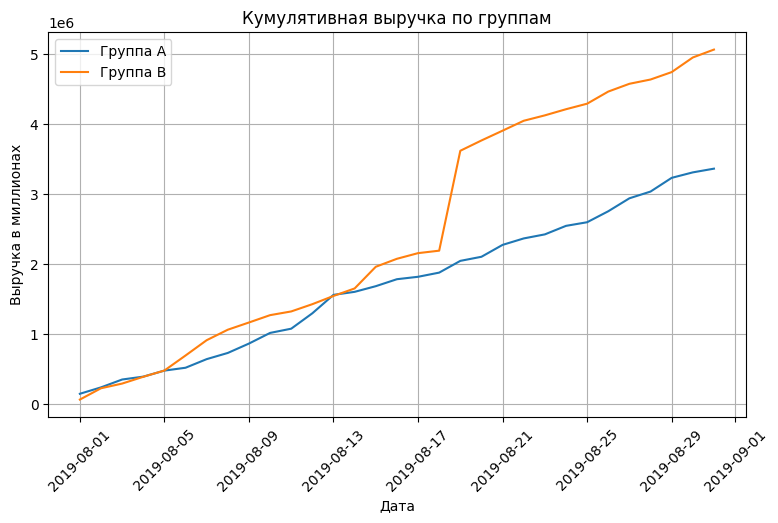

In [25]:
# Датафрейм с кумулятивным количеством заказов, кумулятивной выручкой по дням и кумулятивным количеством посетителей в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]

# Датафрейм с кумулятивным количеством заказов, кумулятивной выручкой по дням и кумулятивным количеством посетителей в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'visitors']]

# Задаём размер «подложки»
plt.figure(figsize = (9, 5))

# Строим график выручки группы А
ax = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
ax = plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')


plt.title('Кумулятивная выручка по группам')
plt.legend(['Группа A', 'Группа B'])
plt.grid(which = "both")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Выручка в миллионах')
plt.show()

Выручка почти равномерно увеличивается до 19 августа, где наблюдается резкий скачок у группы B сразу на ~1.5 миллиона. После данного скачка выручка продолжает равномерно увеличиваться в обеих группах.  
Резкий скачок в группе B скорее всего обусловлен одним или несколькими аномальными заказами.

## График кумулятивного среднего чека по группам

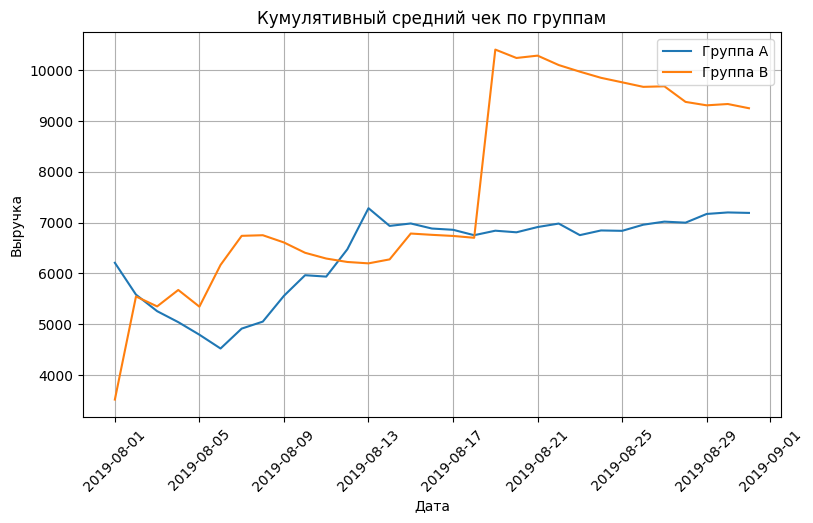

In [26]:
plt.figure(figsize = (9, 5))

# Строим график кумулятивного среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# Строим график кумулятивного среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам')
plt.legend(['Группа A', 'Группа B'])
plt.grid(which = "both")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Выручка')
plt.show()

Средний чек тоже становился равномерным ближе к середине августа, но как и на прошлом графике заметен резкий скачок для группы B, после чего происходит постепенное выравнивание.  
В промежутке между 5 и 9 августа можно заметить ещё большее, чем на предыдущем графике превосходство группы B, которое можем объясняться тем, что в неё в первой половине теста попали крупные заказы.

## График относительного изменения кумулятивного среднего чека группы B к группе A

Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

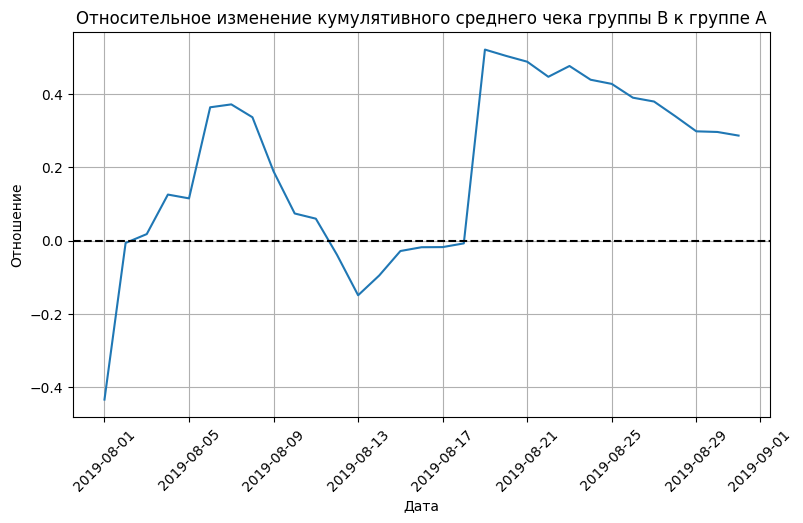

In [27]:
# Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (9, 5))

# Строим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])
    -1
)

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.grid(which = "both")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Отношение')
plt.show()

Всплески размера среднего чека группы B по отношению к группе A в промежутке 5-9, а также 19 августа на графике относительного изменения стали ещё более выразительными. 

## График кумулятивного среднего количества заказов на посетителя по группам

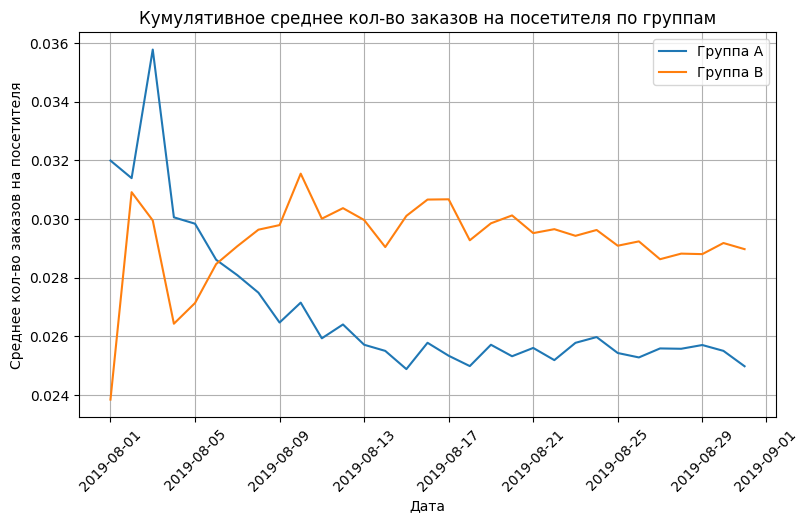

In [28]:
plt.figure(figsize = (9, 5))

# Строим кумулятивное среднее кол-во заказов на посетителя группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['orders']/cumulativeRevenueA['visitors'], label='A')

# Строим кумулятивное среднее кол-во заказов на посетителя группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders']/cumulativeRevenueB['visitors'], label='B')

plt.title('Кумулятивное среднее кол-во заказов на посетителя по группам')
plt.legend(['Группа A', 'Группа B'])
plt.grid(which = "both")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.show()

Среднее количество заказов на посетителя становится более равномерным ближе к концу теста: установился для группы A и заметно незначительное падение для группы B. При этом показатели группы B заметно лучше. Аномальный скачок в группе A свидетельствует о вероятно аномально большом количестве заказов в начале месяца.

## График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

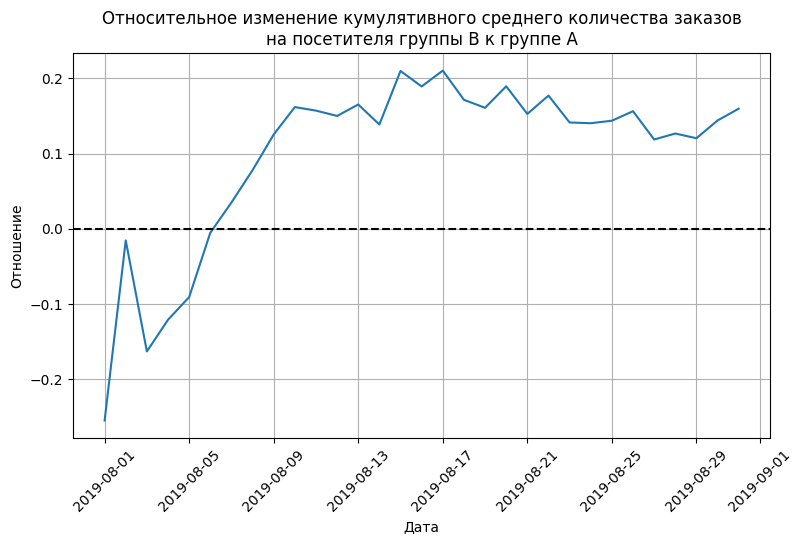

In [29]:
plt.figure(figsize = (9, 5))

# Строим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['ordersB']/mergedCumulativeRevenue['visitorsB'])
    /(mergedCumulativeRevenue['ordersA']/mergedCumulativeRevenue['visitorsA'])
    -1
)

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего количества заказов\nна посетителя группы B к группе A')
plt.grid(which = "both")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Отношение')
plt.show()

На графике относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A хорошо заметно, что в начале месяца для группы B был провал связанный с аномальным скачком в группе A, далее до 9 августа шло выравнивание, после чего график стабилизировался.

## Итоги анализа кумулятивных данных <a id='Итоги_анализа_кумулятивных_данных'></a>
Выручка в обеих группах увеличивается равномерно за исключением 19 августа, когда наблюдался резкий скачок у группы B, после чего выручка продолжила равномерно увеличиваться в обеих группах.

Средний чек становился равномерным во второй половине августа. В графике по среднему чеку для группы B также заметен резкий скачок 19 августа.  
В относительном изменении размера среднего чека группы B по отношению к группе A также видно, что в промежутке 5-9 августа средний чек у группы B был значительно выше.  
После скачка 19 августа происходит постепенное выравнивание относительного изменения размера среднего чека группы B по отношению к группе A.

Кумулятивное среднее количество заказов на посетителя группы B больше, чем у группы A с 7 августа и до конца месяца. Не смотря на то, что в начале месяца для группы B был провал связанный с аномальным скачком в группе A, далее до 9 августа шло выравнивание, после чего график стабилизировался.

# Анализ выбросов и всплесков <a id='spikes'></a>

## Точечный график количества заказов по пользователям

In [30]:
# Группируем заказы по пользователям

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1
...,...,...
968,4259830713,1
969,4278982564,1
970,4279090005,1
971,4281247801,1


In [31]:
# Переименовываем столбец transaction_id в transactions
ordersByUsers.columns = ['visitor_id', 'transactions']

# Сортируем пользователей по кол-ву заказов
ordersByUsers.sort_values(by='transactions', ascending=False)

,visitor_id,transactions
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


Максимальное кол-во заказов на одного пользователя — 3.

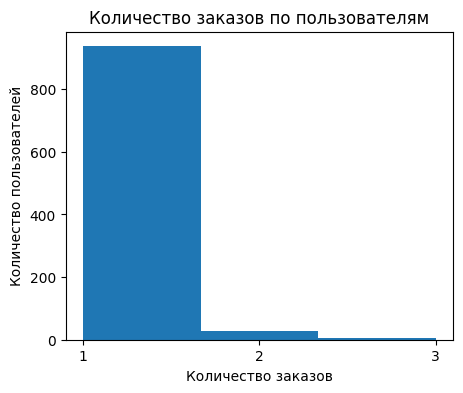

In [32]:
plt.figure(figsize = (5, 4))

# Строим гистограмму количества заказов по пользователям
plt.hist(ordersByUsers['transactions'], bins=3) 
plt.gca().set_xticks(ordersByUsers["transactions"].unique())
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Большинство покупателей делало только 1 заказ. Значительно меньше пользователей сделало 2 заказа и очень малое кол-во пользователей сделали 3.

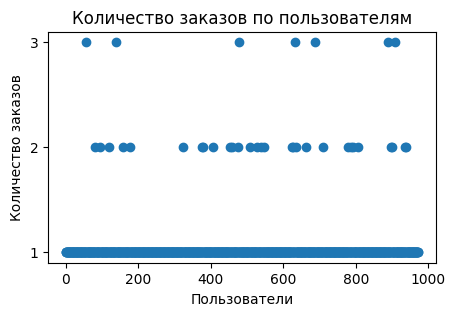

In [33]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize = (5, 3))

# Строим диаграмму количества заказов по пользователям
plt.scatter(x_values, ordersByUsers['transactions'])
plt.gca().set_yticks(ordersByUsers["transactions"].unique())
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Выводы подтверждаются: много пользователей с 1 заказом, с 2 заказми меньше и совсем мало пользователей с 3 заказами.

## 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей

In [34]:
# Находим 95-й и 99-й перцентили количества заказов на пользователя

print(np.percentile(ordersByUsers['transactions'], [95, 99]))

[1. 2.]


Не более 95% пользователей оформляли только 1 заказ. И не более 5% пользователей оформили более 1 заказа.  
На основе полученных данных, границей для определения аномальных будет являться не более 2 заказов на одного пользователя.

## Точечный график стоимостей заказов <a id='всплеск_выручки'></a>

In [35]:
# Сортируем заказы по стоимости

orders.sort_values(by='revenue', ascending=False)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
...,...,...,...,...,...
404,2052514069,1995481842,2019-08-28,70,B
933,3760662696,3577713868,2019-08-27,60,B
584,1126146019,2705308997,2019-08-20,50,A
756,125335873,3423937755,2019-08-30,50,B


Максимальная сумма заказа составляет 1294500 и принадлежит группе B. При этом данная стоимость более чем в 6 раз больше от ближайшего по стоимости заказа. Данный заказ от 19 августа стал виновником скачка на [графиках кумулятивных данных](#Графики_кумулятивных_данных) по выручке и среднему чеку. И только два заказа имеют выручку более 200000, выручка остальных заказов менее 100000.  
Минимальная сумма заказа равна 50.

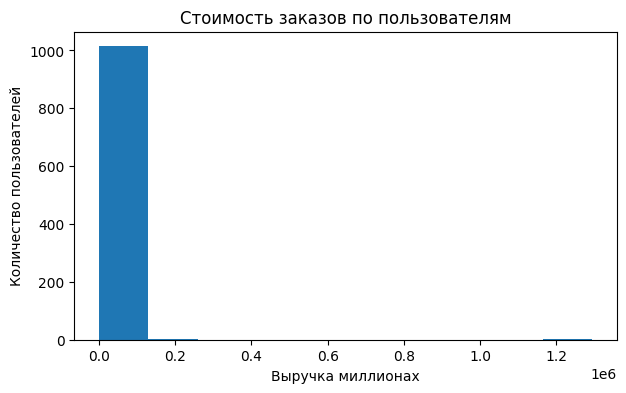

In [36]:
plt.figure(figsize = (7, 4))

plt.hist(orders['revenue']) 
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Выручка миллионах')
plt.ylabel('Количество пользователей')
plt.show()

Гистограмма демонстрирует, что подавляющее число заказов не превышают 200000.

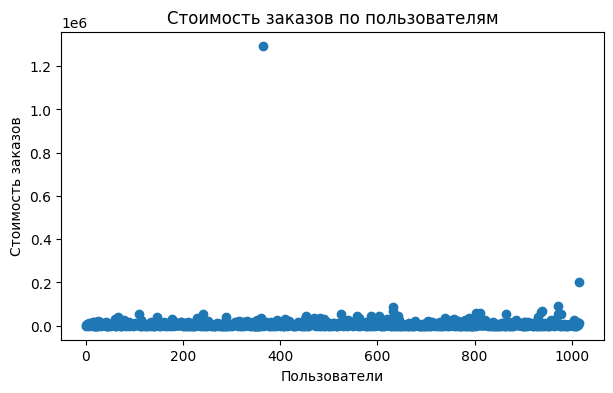

In [37]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize = (7, 4))
plt.scatter(x_values, orders['revenue']) 
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

Точечный график также наглядно демострирует, что только два заказа имют выручку более 200000.

Стоит рассмотреть подробнее заказы с выручкой менее 100000:

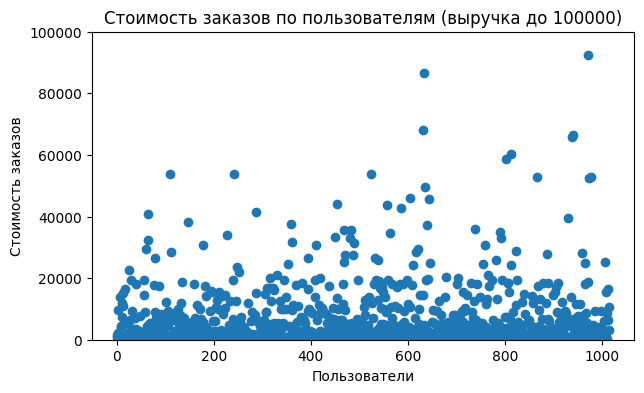

In [38]:
plt.figure(figsize = (7, 4))
plt.scatter(x_values, orders['revenue']) 
plt.title('Стоимость заказов по пользователям (выручка до 100000)')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.ylim(0, 100000)
plt.show()

На точечном графике заказов с выручкой менее 100000 хорошо заметно, что большая часть заказов имеют выручку до 20000.

## 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов

In [54]:
# Находим 95-й и 99-й перцентили стоимости заказов

print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 26785 и не более 1% дороже 53904. В данном случае границей для выбора аномальных заказов можно выбрать выручку более 40000.

## Итоги анализа выбросов и всплесков данных <a id='Итоги_анализа_выбросов'></a>
Согласно проведённому анализу:
- Пользователи совершали от 1 до 3 заказов. При этом 3 заказа совершили менее 1% пользователей;
- Имеются сильные выбросы в стоимости заказов. Заказ с наибольшей стоимостью в 6 раз превосходит заказ на втором месте по стоимости, а он в свою очередь также более чем в два раза отрывается от заказа на третьем месте. При этом менее 5% заказов имею стоимость более 26785.

Примем за аномальные значения следующие:
- Пользователей, кто совершил более 2 заказов (менее 1%);
- Заказы дороже 40 000 (менее 5%).

# Подсчёт статистической значимости <a id ='statistical_significance'></a>

## Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Подготовка данных для посчёта статистической значимости различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей:

In [40]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Данные сформированы успешно.

Описание столбцов:
- **date** — дата;
- **ordersPerDateA** — количество заказов в выбранную дату в группе A;
- **revenuePerDateA** — суммарная выручка в выбранную дату в группе A;
- **ordersPerDateB** — количество заказов в выбранную дату в группе B;
- **revenuePerDateB** — суммарная выручка в выбранную дату в группе B;
- **ordersCummulativeA** — суммарное число заказов до выбранной даты включительно в группе A;
- **revenueCummulativeA** — суммарная выручка до выбранной даты включительно в группе A;
- **ordersCummulativeB** — суммарное количество заказов до выбранной даты включительно в группе B;
- **revenueCummulativeB** — суммарная выручка до выбранной даты включительно в группе B;
- **visitorsPerDateA** — количество пользователей в выбранную дату в группе A;
- **visitorsPerDateB** — количество пользователей в выбранную дату в группе B;
- **visitorsCummulativeA** — количество пользователей до выбранной даты включительно в группе A;
- **visitorsCummulativeB** — количество пользователей до выбранной даты включительно в группе B.

Сформулируем гипотезы:
- Нулевая: различий в среднем количестве заказов между группами нет;
- Альтернативная: различия в среднем между группами есть.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

Создадим переменные *ordersByUsersA* и *ordersByUsersB* со столбцами 'visitor_id' и 'transactions'. В них для пользователей укажем число совершённых заказов. 

In [41]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'transactions']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'transactions']

Объявим переменные *sampleA* и *sampleB*, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [42]:
sampleA = pd.concat(
    [
        ordersByUsersA['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой:

In [43]:
stats.mannwhitneyu(sampleA, sampleB)[1].round(3)

0.011

P-value равен 0.011, что меньше 0.05. Значит согласно «сырым» данным **отвергаем** нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет.

In [44]:
(sampleB.mean() / sampleA.mean() - 1).round(3)

0.16

Выигрыш группы B равен 16%.

Полученные данные говорят о том, что согласно «сырым» данным группа B выгодно отличается по среднему числу заказов на посетителя и это отличие от группы A является статистически значимым.

## Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:
- Нулевая: различий в среднем чеке заказа между группами нет;
- Альтернативная: различия в среднем между группами есть.

In [45]:
stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1].round(3)

0.829

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

In [46]:
(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1).round(3)

0.287

Средний чек группы B выше среднего чека группы A на 28.7%.

Полученные данные говорят о том, что согласно «сырым» данным группа B выгодно отличается по среднему чеку заказа, но статистически значимого различия от группы при этом нет.

## Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным <a id='очищенные_данные'></a>

Согласно [итогам анализа выбросов](#Итоги_анализа_выбросов) и всплесков, примаем за аномальных пользователей тех, кто более 2 заказов или совершил заказ дороже 40 000 рублей:

In [47]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactions'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['transactions'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers.shape[0]

30

Всего 30 аномальных пользователей.

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным:

In [48]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
) 

Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой:

In [49]:
stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1].round(3)

0.004

P-value изменился в меньшую сторону и стал равен 0.004, что соответственно по-прежнему меньше 0.05. Значит согласно «очищенным» данным **отвергаем** нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет.

In [50]:
(sampleBFiltered.mean()/sampleAFiltered.mean()-1).round(3)

0.205

Выигрыш группы B равен 20.5%, что ещё больше по сравнению с результатами полученными на «сырых» данных.

Полученные данные говорят о том, что согласно «очищенным» данным группа B выгодно отличается по среднему числу заказов на посетителя и это отличие от группы A является статистически значимым.

## Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [51]:
stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1].round(3)

0.829

In [52]:
stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
        )
    ]['revenue'],
)[1].round(3)

0.937

P-value после очистки данных увеличился. Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему нет.

In [53]:
(
    orders[
    np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
    )
]['revenue'].mean()
/ orders[
    np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
    )
]['revenue'].mean()
- 1
).round(3)

0.055

Средний чек группы B снова выше среднего чека группы A на 5.5% согласно результатам полученным на «очищенных» данных. Но это значительно меньше, чем 28.7% полученных на «сырых» данных.

Полученные данные говорят о том, что согласно «сырым» данным группа B превосходит группу A по среднему чеку заказа, но статистически значимого различия от группы при этом нет.

## Итоги подсчёта статистической значимости
- Имеется статистически значимое различия по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий.  
При этом выигрыш группы B над группой A по среднему количеству заказов составил:
    - 16% согласно «сырым» данным;
    - 20.5% согласно «очищенным» данным.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.  
При этом выигрыш группы B над группой A по среднему чеку заказа составил:
    - 28.7% согласно «сырым» данным;
    - 5.5% согласно «очищенным» данным.

# Решение по результатам теста <a id='decision'></a>
По результатам анализа результатов A/B-теста, **тест следует остановить**. Поскольку согласно [графикам кумулятивных данных](#Итоги_анализа_кумулятивных_данных), значения выручки, среднего чека и среднего количества заказов на посетителя, стабилизируются к концу месяца и нет необходимости продолжать наблюдение.

Группа B является победителем по среднему количеству заказов.

Различия по среднему чеку между группами отсутствуют.

# Общий вывод по результатам анализа A/B-теста <a id='общий_вывод'></a>

Анализ «сырых» кумулятивных данных показал, что во второй половине августа у группы B наблюдался аномальный всплеск в показателях выручки и среднего чека, который удалось [локализовать](#всплеск_выручки) на этапе анализа выросов и всплесков и [устранить](#очищенные_данные) при подсчёте статистической значимости.  
Наиболее наглядным является *среднее кол-во заказов на посетителя*, т.к. не характеризуется всплесками и во второй половине теста группа B показала стабильно более высокий результат.
В целом во всех кумулятивных данных наблюдаются всплески в начале теста, что связано с малым количеством наблюдений. К концу теста для каждого из показателей наблюдается стабилизация графика.

По результатам проведённого анализа выбросов и всплесков данных удалось исключить из анализа 30 следующих аномальных записей:
- Пользователей, кто совершил более 2 заказов (менее 1%);
- Заказы дороже 40 000 (менее 5%).

## Результаты анализа теста групп A и B
Результаты сравнения между собой групп A и B по **среднему количеству заказов на посетителя** показали статистически значимый выигрыш группы B:
- 16% согласно «сырым» данным;
- 20.5% согласно «очищенным» данным.

А при сравнении между собой групп A и B по **среднему чеку**, нельзя говорить что одна группа превосходит другую, т.к. статистически значимого различия одной группы от другой, нет. При этом оносительные показатели выигрыша группы B над группой A следующие:
- 28.7% согласно «сырым» данным;
- 5.5% согласно «очищенным» данным.

## Решение по результатам теста
По результатам анализа результатов A/B-теста, **тест следует остановить**.  
Гипотезу проверяемую в тесте следует признать для группы B следует признать успешной, она выступила победителем по среднему количеству заказов.  
При этом различия по среднему чеку между группами отсутствуют.